### ## 1. 更新式の役割：「フラットトップ」を唯一の安定点に設定する

> もしかして、フラットトップの時に停止するような更新式ならなんでも良いのか

✅ **その通りです。** アルゴリズム設計の要点は、**「更新が止まる安定点（Fixed Point）が、数学的にフラットトップ状態と一致する」**ような更新ルールを考案することです。

今回提案した加算的更新 `W - α(P - P_avg)` は、その条件を満たす安定的で効果的な一例にすぎません。理論上は、同じ性質を持つ他の安定した更新式でも構いません。

---

### ## 2. SAの役割：「与えられた重み」の下でエネルギーを最大化する

> そしてその重みでえねるぎーを最大化する的な感じか

🎯 **まさにその通りです。** ここには明確な**役割分担**があります。

* **外側ループ（更新式）の役割:** スペクトルを平坦化するためには、次にどの周波数帯を「重要視」すべきか（あるいは「軽視」すべきか）を考え、**最適な「重み $W_t$」を決定します。**
* **内側ループ（SA）の役割:** 外側ループから与えられたその「重み $W_t$」を絶対的なルールとして受け入れ、そのルール下で**重み付きエネルギー $\int W_t(k) P(k) dk$ が最大になるような構造 $\kappa(z)$ を全力で探します。**

この2つのプロセスが連携することで、全体として平坦化へと進んでいきます。

---

### ## 3. 緩やかな更新の役割：「過去」と「現在」を繋ぎ、安定させる

> また、更新を少しづつ行うことで、前の重みがちゃんと意味を持つことを保証するのか

🔗 **その理解も完璧です。** これが安定性の鍵です。

緩やかな更新（小さい学習率 `α`）は、**「過去の情報（直前の重み $W_t$ と、それによって得られたスペクトル $P_t$）」の有効性を保証する**ために不可欠です。

重みを少ししか変えないことで、「$W_t$ の世界」と「$W_{t+1}$ の世界」が非常に近くなります。そのため、「$W_t$ の世界で得られた『平坦化へのヒント（エラー情報）』」が、「$W_{t+1}$ の世界」でも依然として信頼できる道しるべとして機能するのです。

これにより、アルゴリズムは過去の経験を活かしながら着実に進むことができ、発振を防ぐことができます。

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import time
from functools import partial
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.signal import czt

# JAX設定：倍精度浮動小数点数を有効化
from jax import config
config.update("jax_enable_x64", True)


# --- JAXのカスタムCZT関数 (変更なし) ---
@partial(jax.jit, static_argnames=('m', 'fft_len'))
def custom_czt_jax(x, m, fft_len, w, a=1.0):
    """
    JAX implementation of the Chirp Z-Transform.
    """
    n = x.shape[-1]
    n_range = jnp.arange(n)
    y = x * (a**-n_range) * w**(n_range**2 / 2)
    k_range_full = jnp.arange(-(n - 1), m)
    h = w**(-(k_range_full**2) / 2)
    Y = jnp.fft.fft(y, n=fft_len)
    H = jnp.fft.fft(h, n=fft_len)
    conv_result = jnp.fft.ifft(Y * H)
    k_range_out = jnp.arange(m)
    final_chirp = w**(k_range_out**2 / 2)
    return conv_result[n-1:n-1+m] * final_chirp


# --- パラメータ変換 (変更なし) ---
def convert_physical_to_intuitive_params(phys_params):
    """
    物理パラメータをシミュレーションで使いやすいパラメータに変換します。
    """
    L_phys = phys_params["L"]
    Lambda_c = phys_params["center_period"]
    dz_phys = phys_params["dz"]
    B_scale = phys_params["bandwidth_scale"]
    fs = int(L_phys / dz_phys)
    target_center_k = L_phys / Lambda_c
    target_bandwidth = 2.0 * B_scale
    return {
        "L": 2 * np.pi, "M": 1000, "fs": fs,
        "target_bandwidth": target_bandwidth,
        "target_center_k": target_center_k,
    }


# --- JAXベースのAnsatz生成 (変更なし) ---
def create_lfm_ansatz_jax(params):
    """
    線形周波数変調（LFM）信号を初期アンザッツとして生成します。
    """
    L, fs = params["L"], params["fs"]
    target_center_k, target_bw = params["target_center_k"], params["target_bandwidth"]
    k_start, k_end = target_center_k - target_bw / 2, target_center_k + target_bw / 2
    z = jnp.linspace(-L/2, L/2, fs, endpoint=False)
    inst_phase = k_start * z + (k_end - k_start) / L * (z**2 / 2 + L/2 * z)
    signal = jnp.sign(jnp.cos(inst_phase))
    change_points = jnp.where(jnp.diff(signal) != 0)[0] + 1
    db = jnp.concatenate([jnp.array([0]), change_points, jnp.array([fs])])
    starts, ends = db[:-1], db[1:]
    valid_mask = starts < ends
    domains = jnp.stack([starts, ends], axis=1)[valid_mask]
    return signal, domains


def create_constant_period_ansatz_jax(params):
    """
    定周期信号を初期アンザッツとして生成します。
    """
    L, fs, k_center = params["L"], params["fs"], params["target_center_k"]
    z = jnp.linspace(-L/2, L/2, fs, endpoint=False)
    signal = jnp.sign(jnp.cos(k_center * z))
    change_points = jnp.where(jnp.diff(signal) != 0)[0] + 1
    db = jnp.concatenate([jnp.array([0]), change_points, jnp.array([fs])])
    starts, ends = db[:-1], db[1:]
    valid_mask = starts < ends
    domains = jnp.stack([starts, ends], axis=1)[valid_mask]
    return signal, domains


# --- JAXベースのコスト関数 ---
def create_cost_function_jax(params, weights):
    """
    与えられた重みに基づいて、重み付きスペクトル強度を最大化するためのコスト関数を生成します。
    """
    L, fs, M = params["L"], params["fs"], params["M"]
    target_center_k, target_bw = params["target_center_k"], params["target_bandwidth"]
    k_start, k_end = target_center_k - target_bw / 2, target_center_k + target_bw / 2
    f_norm_start, f_norm_end = k_start / fs, k_end / fs
    w = jnp.exp(-1j * 2 * jnp.pi * (f_norm_end - f_norm_start) / M)
    a = jnp.exp(1j * 2 * jnp.pi * f_norm_start)
    required_len = fs + M - 1
    fft_len = 1 << (required_len - 1).bit_length()

    @jax.jit
    def cost_function(signal):
        spectrum = custom_czt_jax(
            signal, m=M, fft_len=fft_len, w=w, a=a) * L / fs
        return -jnp.sum(weights * (jnp.abs(spectrum)**2))

    return cost_function


# --- CZT計算用の関数 (変更なし) ---
def calculate_spectrum(signal, params):
    """
    信号のスペクトル強度を計算します。
    """
    L, fs, M = params["L"], params["fs"], params["M"]
    target_center_k, target_bw = params["target_center_k"], params["target_bandwidth"]
    k_start, k_end = target_center_k - target_bw / 2, target_center_k + target_bw / 2
    f_norm_start, f_norm_end = k_start / fs, k_end / fs
    w = jnp.exp(-1j * 2 * jnp.pi * (f_norm_end - f_norm_start) / M)
    a = jnp.exp(1j * 2 * jnp.pi * f_norm_start)
    required_len = fs + M - 1
    fft_len = 1 << (required_len - 1).bit_length()

    spectrum_complex = custom_czt_jax(
        signal, m=M, fft_len=fft_len, w=w, a=a) * L / fs
    return jnp.abs(spectrum_complex)


# --- JAXベースの焼きなまし (変更なし) ---
@jax.jit
def get_neighbour(key, signal, domains_array):
    """
    現在の信号の近傍（一部を反転させたもの）を生成します。
    """
    signal_len, n_domains = signal.shape[0], domains_array.shape[0]
    n_half_domains = n_domains // 2
    key, subkey = random.split(key)
    indices = random.randint(subkey, shape=(
        2,), minval=0, maxval=n_half_domains)
    start_domain_idx, end_domain_idx = jnp.min(indices), jnp.max(indices)
    start_pixel_1, end_pixel_1 = domains_array[start_domain_idx,
                                               0], domains_array[end_domain_idx, 1]
    symmetric_start_idx, symmetric_end_idx = n_domains - \
        1 - end_domain_idx, n_domains - 1 - start_domain_idx
    start_pixel_2, end_pixel_2 = domains_array[symmetric_start_idx,
                                               0], domains_array[symmetric_end_idx, 1]
    all_indices = jnp.arange(signal_len)
    mask = ((all_indices >= start_pixel_1) & (all_indices < end_pixel_1)) | \
           ((all_indices >= start_pixel_2) & (all_indices < end_pixel_2))
    return jnp.where(mask, -signal, signal)


def run_simulated_annealing_jax(key, initial_signal, domains_array, cost_fn, sa_params):
    """
    JAXを使用してシミュレーテッドアニーリング（焼きなまし法）を実行します。
    """
    n_iter, cooling_rate, batch_size = sa_params[
        "n_iterations"], sa_params["cooling_rate"], sa_params["batch_size"]
    vmap_get_neighbour = jax.vmap(get_neighbour, in_axes=(0, None, None))
    vmap_cost_fn = jax.vmap(cost_fn)
    initial_cost = cost_fn(initial_signal)
    init_val = (key, initial_signal, initial_cost, initial_signal, initial_cost,
                sa_params["initial_temp"], jnp.zeros(n_iter + 1).at[0].set(initial_cost))

    @jax.jit
    def sa_step(i, val):
        key, current_signal, current_cost, best_signal, best_cost, temp, cost_history = val
        key, mutate_key, accept_key = random.split(key, 3)
        batch_keys = random.split(mutate_key, batch_size)
        neighbor_batch = vmap_get_neighbour(
            batch_keys, current_signal, domains_array)
        cost_batch = vmap_cost_fn(neighbor_batch)
        best_in_batch_idx = jnp.argmin(cost_batch)
        best_neighbor_signal, best_neighbor_cost = neighbor_batch[
            best_in_batch_idx], cost_batch[best_in_batch_idx]
        acceptance_prob = jnp.exp(-(best_neighbor_cost - current_cost) / temp)
        accept = (best_neighbor_cost < current_cost) | (
            random.uniform(accept_key) < acceptance_prob)
        current_signal = jnp.where(
            accept, best_neighbor_signal, current_signal)
        current_cost = jnp.where(accept, best_neighbor_cost, current_cost)
        is_better = current_cost < best_cost
        best_signal = jnp.where(is_better, current_signal, best_signal)
        best_cost = jnp.where(is_better, current_cost, best_cost)
        new_temp = temp * cooling_rate
        cost_history = cost_history.at[i + 1].set(best_cost)
        return (key, current_signal, current_cost, best_signal, best_cost, new_temp, cost_history)

    final_val = jax.lax.fori_loop(0, n_iter, sa_step, init_val)
    _, _, _, best_signal, best_cost, _, cost_history = final_val
    return best_signal, best_cost


# --- 結果プロット用のヘルパー関数 (変更なし) ---
def get_domains_from_signal(signal):
    """信号からドメイン（+1/-1が連続する区間）を計算するヘルパー関数"""
    fs = signal.shape[0]
    change_points = jnp.where(jnp.diff(signal) != 0)[0] + 1
    db = jnp.concatenate([jnp.array([0]), change_points, jnp.array([fs])])
    starts, ends = db[:-1], db[1:]
    valid_mask = starts < ends
    domains = jnp.stack([starts, ends], axis=1)[valid_mask]
    return np.array(domains)

In [2]:
# --- パラメータ設定 ---
physical_parameters = {
    "L": 5e6, "center_period": 7200, "dz": 100,
    "bandwidth_scale": 1.2
}
opt_params = convert_physical_to_intuitive_params(physical_parameters)

sa_params = {
    "initial_temp": 5,
    "cooling_rate": 0.999,
    "n_iterations": 10000,
    "batch_size": 1
}

# --- 適応的alphaのパラメータ設定 (変更なし) ---
adaptive_alpha_params = {
    "initial_alpha": 0.2,
    "min_alpha": 1e-6,
    "max_alpha": 0.2,
    "increase_factor": 1.5,  # 分散の変化が小さい場合にalphaを大きくする係数
    "decrease_factor": 0.5,  # 分散の変化が大きい場合にalphaを小さくする係数
    "variance_change_threshold": 0.05  # 分散の変化率がこれより大きいと「変化が大きい」と判断
}

# --- 【変更】メインの最適化ループ ---
key = random.PRNGKey(int(time.time()))
initial_signal, domains = create_constant_period_ansatz_jax(opt_params)

n_outer_loops = 50
epsilon = 1e-8

current_signal = initial_signal
weights = jnp.ones(opt_params["M"], dtype=jnp.float64)

# 適応的alphaを初期化
alpha = adaptive_alpha_params["initial_alpha"]

history_spectra = []
history_weights = []
history_alpha = []  # alphaの履歴を保存するリスト

print("--- Starting Iterative Weighted Optimization with Adaptive Alpha (Spectrum-based) ---")

initial_spectrum = calculate_spectrum(current_signal, opt_params)
history_spectra.append(initial_spectrum)
history_weights.append(weights)
history_alpha.append(alpha)  # 最初のalphaを保存

start_time_total = time.time()
for i in range(n_outer_loops):
    print(f"\n--- Outer Loop Iteration: {i+1}/{n_outer_loops} ---")
    # このイテレーションで使われるalphaを表示
    print(f"Current alpha for weight update: {alpha:.5f}")

    # 1. 現在の重みでコスト関数を作成し、SAを実行
    cost_calculator = create_cost_function_jax(opt_params, weights)
    key, sa_key = random.split(key)
    current_signal, best_cost = run_simulated_annealing_jax(
        sa_key, current_signal, domains, cost_calculator, sa_params
    )
    print(f"SA finished. Best cost (weighted power): {-best_cost:.4g}")

    # 2. 新しいスペクトルを計算
    spectrum = calculate_spectrum(current_signal, opt_params)

    # 3. 新しい重み候補を計算
    raw_new_weights = 1.0 / (spectrum + epsilon)
    raw_new_weights = raw_new_weights / jnp.mean(raw_new_weights)

    # 4. "現在の"alphaを使って重みを更新
    weights = (1 - alpha) * weights + alpha * raw_new_weights
    weights = jnp.clip(weights, 0.1, 10.0)

    # 5. 【ロジック変更】スペクトル分散の変化に基づき、"次"のイテレーションで使うalphaを決定
    var_current_spectrum = jnp.var(spectrum)
    # 前回のスペクトルはhistoryから取得
    var_previous_spectrum = jnp.var(history_spectra[-1])

    # 分散の変化率を計算 (ゼロ除算を回避)
    variance_change_ratio = jnp.abs(
        var_current_spectrum - var_previous_spectrum) / (var_previous_spectrum + epsilon)
    print(f"Spectrum variance change ratio: {variance_change_ratio:.4f}")

    is_change_large = variance_change_ratio > adaptive_alpha_params["variance_change_threshold"]

    new_alpha = jax.lax.cond(
        is_change_large,
        # 変化が大きい -> alphaを減らす
        lambda a: a * adaptive_alpha_params["decrease_factor"],
        # 変化が小さい -> alphaを増やす
        lambda a: a * adaptive_alpha_params["increase_factor"],
        alpha
    )
    # alphaを最小値と最大値の範囲にクリップ
    alpha = jnp.clip(
        new_alpha, adaptive_alpha_params["min_alpha"], adaptive_alpha_params["max_alpha"])

    # 6. 履歴を保存 (次のループで使うalphaを保存)
    history_spectra.append(spectrum)
    history_weights.append(weights)
    history_alpha.append(alpha)

end_time_total = time.time()
print(
    f"\n--- Total Optimization Finished in {end_time_total - start_time_total:.2f} seconds ---")
print(f"Final alpha: {alpha:.5f}")

--- Starting Iterative Weighted Optimization with Adaptive Alpha (Spectrum-based) ---

--- Outer Loop Iteration: 1/50 ---
Current alpha for weight update: 0.20000
SA finished. Best cost (weighted power): 6045
Spectrum variance change ratio: 0.0000

--- Outer Loop Iteration: 2/50 ---
Current alpha for weight update: 0.20000
SA finished. Best cost (weighted power): 5020
Spectrum variance change ratio: 0.0000

--- Outer Loop Iteration: 3/50 ---
Current alpha for weight update: 0.20000
SA finished. Best cost (weighted power): 4200
Spectrum variance change ratio: 0.0000

--- Outer Loop Iteration: 4/50 ---
Current alpha for weight update: 0.20000
SA finished. Best cost (weighted power): 4037
Spectrum variance change ratio: 0.7490

--- Outer Loop Iteration: 5/50 ---
Current alpha for weight update: 0.10000
SA finished. Best cost (weighted power): 4244
Spectrum variance change ratio: 2.5209

--- Outer Loop Iteration: 6/50 ---
Current alpha for weight update: 0.05000
SA finished. Best cost (wei

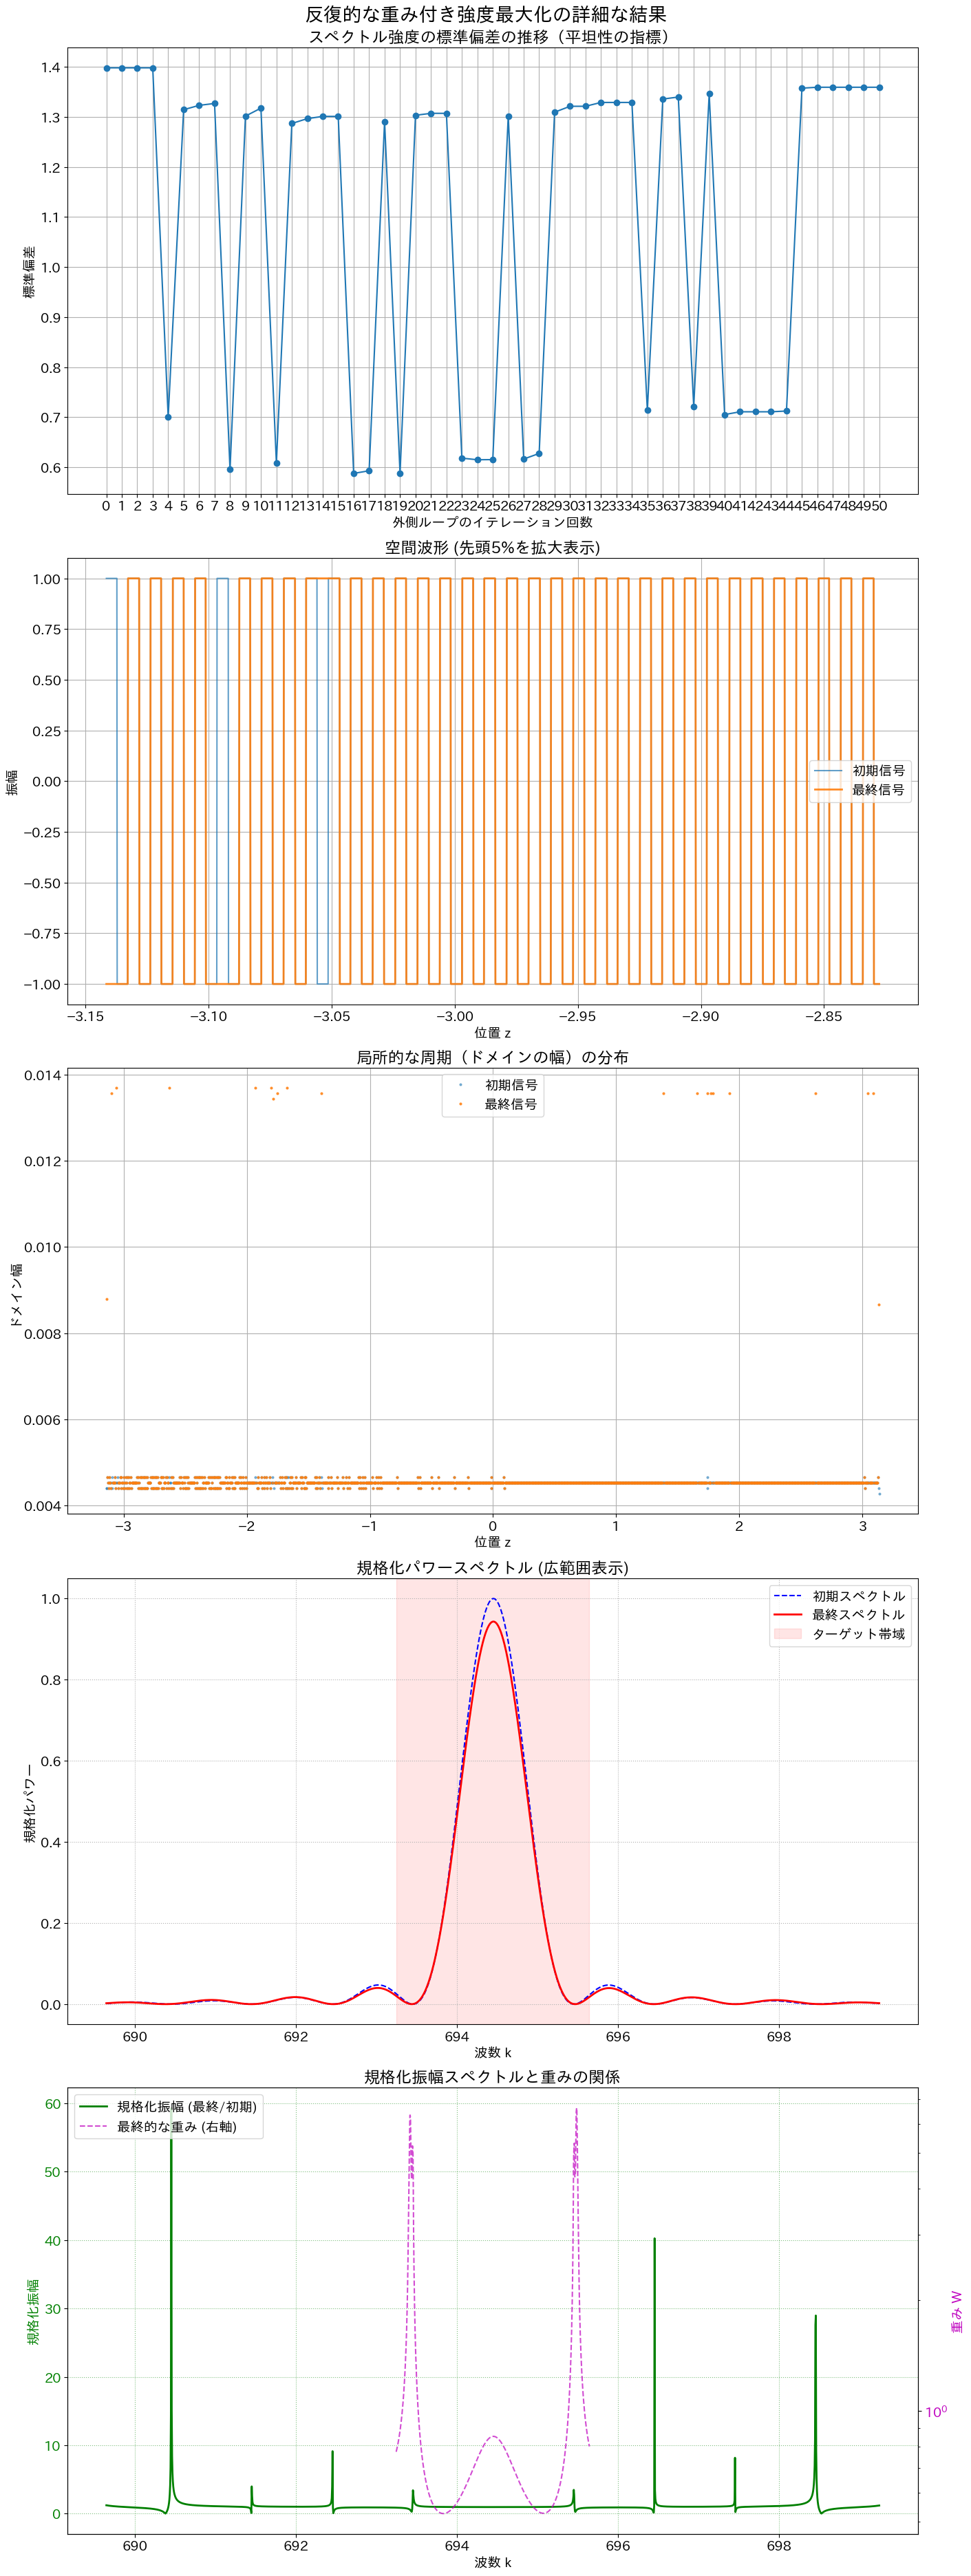

In [3]:
# --- 【更新】高機能な結果プロット関数 ---
def plot_iterative_results(initial_sig, final_sig, history_spectra, history_weights, params, epsilon=1e-8):
    """
    反復最適化の結果を多角的にプロットする。
    - スペクトル平坦性の推移
    - 空間波形のズーム表示
    - 局所周期の分布
    - 規格化パワースペクトルと規格化振幅スペクトル
    """
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(5, 1, figsize=(
        14, 28*4/3), constrained_layout=True)
    fig.suptitle("反復的な重み付き強度最大化の詳細な結果", fontsize=20)

    L, fs, M = params["L"], params["fs"], params["M"]
    target_center_k, target_bw = params["target_center_k"], params["target_bandwidth"]
    z = np.linspace(-L/2, L/2, fs, endpoint=False)

    initial_sig_np = np.array(initial_sig)
    final_sig_np = np.array(final_sig)

    # 1. スペクトルの平坦性の評価 (標準偏差の推移)
    std_devs = [jnp.std(spec) for spec in history_spectra]
    axes[0].plot(range(len(std_devs)), std_devs, 'o-')
    axes[0].set_title("スペクトル強度の標準偏差の推移（平坦性の指標）")
    axes[0].set_xlabel("外側ループのイテレーション回数")
    axes[0].set_ylabel("標準偏差")
    axes[0].grid(True)
    axes[0].set_xticks(range(len(std_devs)))

    # 2. 空間波形 (先頭5%をズーム)
    zoom_range = int(fs * 0.05)
    axes[1].plot(z[:zoom_range], initial_sig_np[:zoom_range],
                 label='初期信号', alpha=0.7)
    axes[1].plot(z[:zoom_range], final_sig_np[:zoom_range],
                 label='最終信号', alpha=0.9, linewidth=2)
    axes[1].set_title('空間波形 (先頭5%を拡大表示)')
    axes[1].set_xlabel('位置 z')
    axes[1].set_ylabel('振幅')
    axes[1].legend()
    axes[1].grid(True)

    # 3. 局所周期（ドメイン幅）のプロット
    initial_domains = get_domains_from_signal(initial_sig_np)
    final_domains = get_domains_from_signal(final_sig_np)
    initial_domain_pos = z[initial_domains[:, 0]]
    initial_domain_width = (
        initial_domains[:, 1] - initial_domains[:, 0]) * (L/fs)
    final_domain_pos = z[final_domains[:, 0]]
    final_domain_width = (final_domains[:, 1] - final_domains[:, 0]) * (L/fs)
    axes[2].plot(initial_domain_pos, initial_domain_width,
                 'o', markersize=2, alpha=0.5, label='初期信号')
    axes[2].plot(final_domain_pos, final_domain_width, 'o',
                 markersize=2, alpha=0.8, label='最終信号')
    axes[2].set_title('局所的な周期（ドメインの幅）の分布')
    axes[2].set_xlabel('位置 z')
    axes[2].set_ylabel('ドメイン幅')
    axes[2].legend()
    axes[2].grid(True)

    # 4. 周波数スペクトル（広範囲表示＆パワー規格化）
    # --- ▼▼▼ 修正点1: 表示範囲を古い基準に合わせる ▼▼▼ ---
    k_view_width = target_bw * 2.0  # 表示範囲をターゲットの2倍に
    k_start_view = target_center_k - k_view_width
    k_end_view = target_center_k + k_view_width
    f_norm_start_view, f_norm_end_view = k_start_view / fs, k_end_view / fs
    view_M = M * 2  # 表示点数も2倍に
    # --- ▲▲▲ 修正点1 ▲▲▲ ---
    view_czt_params = {'m': view_M, 'w': np.exp(-1j*2*np.pi*(
        f_norm_end_view-f_norm_start_view)/view_M), 'a': np.exp(1j*2*np.pi*f_norm_start_view)}
    k_axis_view = np.linspace(k_start_view, k_end_view, view_M)

    # 表示用にスペクトル振幅を再計算
    initial_spec_view = np.abs(czt(initial_sig_np, **view_czt_params) * L / fs)
    final_spec_view = np.abs(czt(final_sig_np, **view_czt_params) * L / fs)

    # --- ▼▼▼ 修正点2: パワーを計算し、初期値の最大パワーで規格化 ▼▼▼ ---
    initial_power_spec = initial_spec_view**2
    final_power_spec = final_spec_view**2

    # 規格化係数（初期スペクトルの最大パワー）
    norm_factor = np.max(initial_power_spec)

    # ゼロ除算を防止
    if norm_factor < epsilon:
        norm_factor = 1.0

    axes[3].plot(k_axis_view, initial_power_spec /
                 norm_factor, 'b--', label='初期スペクトル')
    axes[3].plot(k_axis_view, final_power_spec /
                 norm_factor, 'r-', lw=2, label='最終スペクトル')
    k_min_target, k_max_target = target_center_k - \
        target_bw / 2, target_center_k + target_bw / 2
    axes[3].axvspan(k_min_target, k_max_target,
                    color='red', alpha=0.1, label='ターゲット帯域')
    axes[3].set_title('規格化パワースペクトル (広範囲表示)')
    axes[3].set_xlabel('波数 k')
    axes[3].set_ylabel('規格化パワー')
    axes[3].legend()
    axes[3].grid(True, linestyle=':')
    # --- ▲▲▲ 修正点2 ▲▲▲ ---

    # 5. 規格化振幅スペクトルと最終的な重み
    normalized_amplitude_spectrum = final_spec_view / \
        (initial_spec_view + epsilon)
    ax5_2 = axes[4].twinx()  # 2軸プロット

    p1, = axes[4].plot(k_axis_view, normalized_amplitude_spectrum,
                       'g-', lw=2, label='規格化振幅 (最終/初期)')
    axes[4].set_xlabel('波数 k')
    axes[4].set_ylabel('規格化振幅', color='g')
    axes[4].tick_params(axis='y', labelcolor='g')
    axes[4].grid(True, linestyle=':', color='g', alpha=0.5)

    # 重みはターゲット帯域内でのみ定義されているので、対応するk軸を作成
    k_min_target, k_max_target = target_center_k - \
        target_bw / 2, target_center_k + target_bw / 2
    k_axis_target = np.linspace(k_min_target, k_max_target, M)
    p2, = ax5_2.plot(
        k_axis_target, history_weights[-1], 'm--', alpha=0.7, label='最終的な重み (右軸)')
    ax5_2.set_ylabel('重み W', color='m')
    ax5_2.tick_params(axis='y', labelcolor='m')
    ax5_2.set_yscale('log')

    axes[4].set_title('規格化振幅スペクトルと重みの関係')
    axes[4].legend(handles=[p1, p2], loc='upper left')

    plt.show()


# --- 【変更】新しい高機能プロット関数を呼び出す ---
plot_iterative_results(initial_signal, current_signal,
                       history_spectra, history_weights, opt_params)